# Dual Momentum Investing

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from utils import historic_cdi

In [2]:
IBOV = yf.Ticker('^BVSP')
SP500 = yf.Ticker('^GSCP')

### IBOV

In [3]:
ibov_prices = IBOV.history(period='max', rounding=True)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date

ibov_prices

1993-04-27        24.5
1993-04-28        24.3
1993-04-29        23.7
1993-04-30        24.1
1993-05-03        24.1
                ...   
2024-08-28    137344.0
2024-08-29    136041.0
2024-08-30    136004.0
2024-09-02    134981.0
2024-09-03    134353.0
Name: Close, Length: 7764, dtype: float64

In [4]:
# cálculo da cota

ibov = ibov_prices.div(ibov_prices.iloc[0])

ibov

1993-04-27       1.000000
1993-04-28       0.991837
1993-04-29       0.967347
1993-04-30       0.983673
1993-05-03       0.983673
                 ...     
2024-08-28    5605.877551
2024-08-29    5552.693878
2024-08-30    5551.183673
2024-09-02    5509.428571
2024-09-03    5483.795918
Name: Close, Length: 7764, dtype: float64

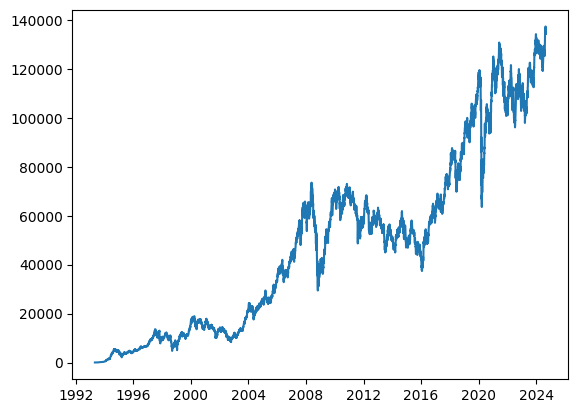

In [5]:
plt.plot(ibov_prices)
plt.show()

In [6]:
# variação diária do índice

ibov_prices_var = ibov_prices.pct_change()
ibov_prices_var = ibov_prices_var[1:len(ibov_prices_var.index)]

ibov_prices_var

1993-04-28   -0.008163
1993-04-29   -0.024691
1993-04-30    0.016878
1993-05-03    0.000000
1993-05-04    0.033195
                ...   
2024-08-28    0.004153
2024-08-29   -0.009487
2024-08-30   -0.000272
2024-09-02   -0.007522
2024-09-03   -0.004653
Name: Close, Length: 7763, dtype: float64

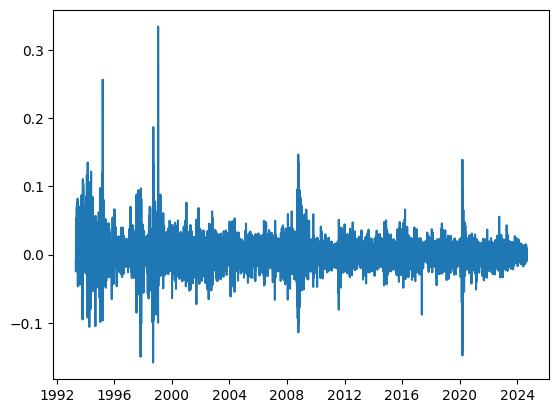

In [7]:
plt.plot(ibov_prices_var)
plt.show()

In [8]:
# retorno médio anualizado

ibov_avg_return = np.mean(ibov_prices_var) * 252

ibov_avg_return

np.float64(0.3379224483864751)

In [9]:
# drawdown

ibov_cum_returns = (1 + ibov_prices_var).cumprod()
ibov_cum_max = ibov_cum_returns.cummax()

drawdown = (ibov_cum_returns - ibov_cum_max) / ibov_cum_max

drawdown

1993-04-28    0.000000
1993-04-29   -0.024691
1993-04-30   -0.008230
1993-05-03   -0.008230
1993-05-04    0.000000
                ...   
2024-08-28    0.000000
2024-08-29   -0.009487
2024-08-30   -0.009757
2024-09-02   -0.017205
2024-09-03   -0.021777
Name: Close, Length: 7763, dtype: float64

In [10]:
round(min(drawdown), 2)

-0.65

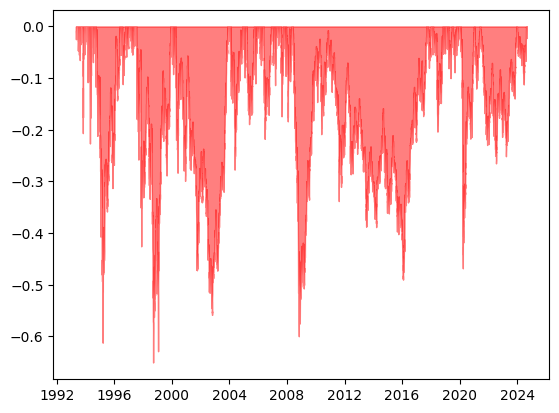

In [11]:
plt.fill_between(x=drawdown.index, y1=drawdown, color='red', alpha=0.5)
plt.show()

In [12]:
ibov_drawdown_shifts = (drawdown < 0).ne((drawdown < 0).shift()).cumsum()
ibov_drawdown_durations = (drawdown < 0).groupby(ibov_drawdown_shifts).size()

print(round(ibov_drawdown_durations.mean()))
print(ibov_drawdown_durations.max())

18
2304


### Absolute Momentum

In [13]:
start_date = datetime.strftime(ibov_prices.index.min(), format='%d/%m/%Y')
end_date = datetime.strftime(ibov_prices.index.max(), format='%d/%m/%Y')

In [14]:
cdi = historic_cdi(start=start_date, end=end_date)
cdi = cdi.div(cdi.iloc[0])

cdi

1993-04-27       1.000000
1993-04-28       1.013950
1993-04-29       1.027888
1993-04-30       1.041693
1993-05-03       1.055360
                 ...     
2024-08-28    9731.598606
2024-08-29    9735.420204
2024-08-30    9739.243304
2024-09-02    9743.067905
2024-09-03    9746.894008
Name: valor, Length: 7870, dtype: float64

In [15]:
returns = pd.concat([ibov, cdi], keys=['IBOV', 'CDI'],  axis=1, join='inner')
returns.index = pd.to_datetime(returns.index)

returns.sort_index()

,IBOV,CDI
1993-04-27,1.000000,1.000000
1993-04-28,0.991837,1.013950
1993-04-29,0.967347,1.027888
1993-04-30,0.983673,1.041693
1993-05-03,0.983673,1.055360
...,...,...
2024-08-28,5605.877551,9731.598606
2024-08-29,5552.693878,9735.420204
2024-08-30,5551.183673,9739.243304
2024-09-02,5509.428571,9743.067905


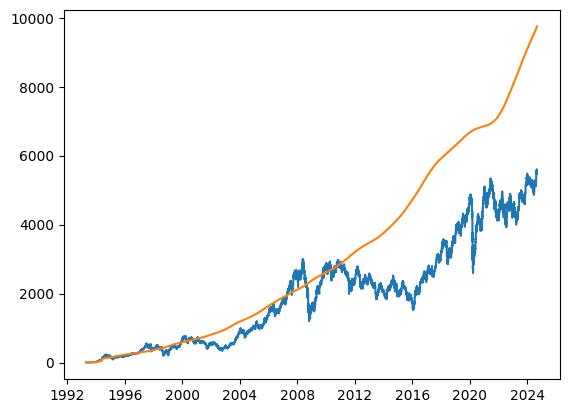

In [16]:
plt.plot(returns)
plt.show()

In [17]:
yearly_performance = returns.pct_change(periods=252).dropna()

yearly_performance

,IBOV,CDI
1994-05-04,63.236735,53.331335
1994-05-05,58.584362,53.527809
1994-05-06,62.725738,53.737763
1994-05-09,57.995851,53.966235
1994-05-10,63.232365,54.221954
...,...,...
2024-08-28,0.173620,0.113843
2024-08-29,0.174418,0.113735
2024-08-30,0.161226,0.113626
2024-09-02,0.140004,0.113517


In [18]:
yearly_performance['Excess Return'] = yearly_performance.apply(lambda x: 'IBOV' if x['IBOV'] > x['CDI'] else 'CDI', axis=1)

yearly_performance['Excess Return'].value_counts()

Excess Return
CDI     3812
IBOV    3697
Name: count, dtype: int64

In [19]:
first_trading_day = yearly_performance.index.to_series().groupby(yearly_performance.index.to_period('M')).apply(lambda x: x == x.min())

yearly_performance['Month Start'] = first_trading_day.values

yearly_performance

,IBOV,CDI,Excess Return,Month Start
1994-05-04,63.236735,53.331335,IBOV,True
1994-05-05,58.584362,53.527809,IBOV,False
1994-05-06,62.725738,53.737763,IBOV,False
1994-05-09,57.995851,53.966235,IBOV,False
1994-05-10,63.232365,54.221954,IBOV,False
...,...,...,...,...
2024-08-28,0.173620,0.113843,IBOV,False
2024-08-29,0.174418,0.113735,IBOV,False
2024-08-30,0.161226,0.113626,IBOV,False
2024-09-02,0.140004,0.113517,IBOV,True


In [20]:
yearly_performance['Investment'] = yearly_performance.loc[yearly_performance['Month Start'], 'Excess Return']
yearly_performance['Investment'] = yearly_performance['Investment'].ffill()

yearly_performance

,IBOV,CDI,Excess Return,Month Start,Investment
1994-05-04,63.236735,53.331335,IBOV,True,IBOV
1994-05-05,58.584362,53.527809,IBOV,False,IBOV
1994-05-06,62.725738,53.737763,IBOV,False,IBOV
1994-05-09,57.995851,53.966235,IBOV,False,IBOV
1994-05-10,63.232365,54.221954,IBOV,False,IBOV
...,...,...,...,...,...
2024-08-28,0.173620,0.113843,IBOV,False,CDI
2024-08-29,0.174418,0.113735,IBOV,False,CDI
2024-08-30,0.161226,0.113626,IBOV,False,CDI
2024-09-02,0.140004,0.113517,IBOV,True,IBOV


In [21]:
returns_var = returns.pct_change().dropna()

absolute_momentum = returns_var.merge(yearly_performance[['Investment']], left_index=True, right_index=True,  how='right')

absolute_momentum['Absolute Momentum'] = absolute_momentum['IBOV']

absolute_momentum.loc[absolute_momentum['Investment'] != 'IBOV', 'Absolute Momentum'] = absolute_momentum['CDI']

absolute_momentum

,IBOV,CDI,Investment,Absolute Momentum
1994-05-04,-0.045256,0.017610,IBOV,-0.045256
1994-05-05,-0.079997,0.017617,IBOV,-0.079997
1994-05-06,0.043097,0.017650,IBOV,0.043097
1994-05-09,-0.058598,0.017660,IBOV,-0.058598
1994-05-10,0.088761,0.017833,IBOV,0.088761
...,...,...,...,...
2024-08-28,0.004153,0.000393,CDI,0.000393
2024-08-29,-0.009487,0.000393,CDI,0.000393
2024-08-30,-0.000272,0.000393,CDI,0.000393
2024-09-02,-0.007522,0.000393,IBOV,-0.007522


In [22]:
absolute_momentum_eval = (1 + absolute_momentum.drop(columns=['Investment'])).cumprod()

absolute_momentum_eval

,IBOV,CDI,Absolute Momentum
1994-05-04,0.954744,1.017610,0.954744
1994-05-05,0.878367,1.035537,0.878367
1994-05-06,0.916222,1.053814,0.916222
1994-05-09,0.862533,1.072424,0.862533
1994-05-10,0.939092,1.091549,0.939092
...,...,...,...
2024-08-28,83.319583,182.269994,244.159529
2024-08-29,82.529119,182.341572,244.255410
2024-08-30,82.506673,182.413177,244.351329
2024-09-02,81.886071,182.484811,242.513358


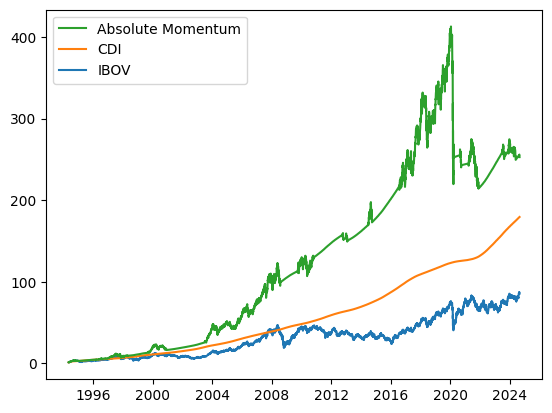

In [23]:
am_eval = absolute_momentum_eval.div(absolute_momentum_eval.iloc[0])

plt.plot(am_eval['IBOV'], label='IBOV')
plt.plot(am_eval['CDI'], label='CDI')
plt.plot(am_eval['Absolute Momentum'], label='Absolute Momentum')
plt.legend(loc='upper left', reverse=True)
plt.show()

In [24]:
am_daily_returns = am_eval.pct_change().dropna()

am_avg_return = am_eval.resample('YE').last().pct_change().mean()
am_avg_volatility = am_daily_returns.std() * (252 ** 0.5)

am_results = pd.concat([am_avg_return, am_avg_volatility], keys=['Avg Return', 'Avg Volatility'], axis=1)

am_results


,Avg Return,Avg Volatility
IBOV,0.179036,0.327477
CDI,0.153405,0.022107
Absolute Momentum,0.192212,0.208743


In [25]:
risk_free_rate = 0.1075

am_results['Sharpe Ratio'] = (am_results['Avg Return'] - risk_free_rate) / am_results['Avg Volatility']

am_results


,Avg Return,Avg Volatility,Sharpe Ratio
IBOV,0.179036,0.327477,0.218445
CDI,0.153405,0.022107,2.076479
Absolute Momentum,0.192212,0.208743,0.405821


### Relative Momentum

In [42]:
start_relative = '2004-01-01'

In [50]:
ibov_prices = IBOV.history(start=start_relative, end=datetime.now(), rounding=True)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date
ibov_prices = (ibov_prices / ibov_prices.iloc[0])

ibov_prices

2004-01-02    1.000000
2004-01-05    1.048429
2004-01-06    1.050390
2004-01-07    1.038984
2004-01-08    1.056672
                ...   
2024-08-28    6.119136
2024-08-29    6.061083
2024-08-30    6.059434
2024-09-02    6.013856
2024-09-03    5.985877
Name: Close, Length: 5119, dtype: float64

In [51]:
sp500_prices = SP500.history(start=start_relative, end=datetime.now(), rounding=True)['Close']
sp500_prices.index = pd.to_datetime(sp500_prices.index).date
sp500_prices = (sp500_prices / sp500_prices.iloc[0])

sp500_prices

2004-01-02    1.000000
2004-01-05    1.012395
2004-01-06    1.013703
2004-01-07    1.016103
2004-01-08    1.021146
                ...   
2024-08-27    5.075238
2024-08-28    5.044908
2024-08-29    5.044710
2024-08-30    5.095626
2024-09-03    4.987848
Name: Close, Length: 5202, dtype: float64

In [52]:
relative_prices = pd.concat([ibov_prices, sp500_prices], keys=['IBOV', 'SP500'], join='inner', axis=1)

relative_prices

,IBOV,SP500
2004-01-02,1.000000,1.000000
2004-01-05,1.048429,1.012395
2004-01-06,1.050390,1.013703
2004-01-07,1.038984,1.016103
2004-01-08,1.056672,1.021146
...,...,...
2024-08-27,6.093829,5.075238
2024-08-28,6.119136,5.044908
2024-08-29,6.061083,5.044710
2024-08-30,6.059434,5.095626


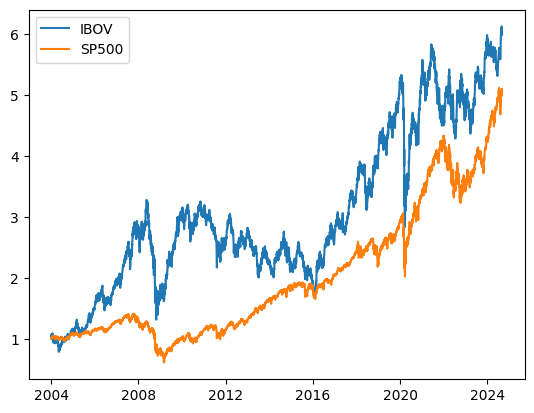

In [53]:
plt.plot(relative_prices)
plt.legend(relative_prices.columns)
plt.show()

In [76]:
relative_ytd_returns = relative_prices.pct_change(periods=252).dropna()
relative_ytd_returns.index = pd.to_datetime(relative_ytd_returns.index)

relative_ytd_returns


,IBOV,SP500
2005-01-18,0.073246,0.078937
2005-01-19,0.031404,0.055613
2005-01-20,0.001442,0.046046
2005-01-21,0.021355,0.036881
2005-01-24,0.020281,0.028120
...,...,...
2024-08-27,0.170927,0.253040
2024-08-28,0.182257,0.260107
2024-08-29,0.176907,0.269651
2024-08-30,0.182829,0.292434


In [100]:
relative_ftd = relative_ytd_returns.index.to_series().groupby(relative_ytd_returns.index.to_period('M')).apply(lambda x: x == x.min())

conditions = [
    relative_ftd.values & (relative_ytd_returns['IBOV'] > relative_ytd_returns['SP500']),
    relative_ftd.values & (relative_ytd_returns['IBOV'] <= relative_ytd_returns['SP500'])
]

relative_ytd_returns['Excess Return'] = np.select(conditions, ['IBOV', 'SP500'], default=None)
relative_ytd_returns['Investment'] = relative_ytd_returns['Excess Return'].ffill()

relative_ytd_returns

,IBOV,SP500,Excess Return,Investment
2005-01-18,0.073246,0.078937,SP500,SP500
2005-01-19,0.031404,0.055613,None,SP500
2005-01-20,0.001442,0.046046,None,SP500
2005-01-21,0.021355,0.036881,None,SP500
2005-01-24,0.020281,0.028120,None,SP500
...,...,...,...,...
2024-08-27,0.170927,0.253040,None,SP500
2024-08-28,0.182257,0.260107,None,SP500
2024-08-29,0.176907,0.269651,None,SP500
2024-08-30,0.182829,0.292434,None,SP500


In [106]:
relative_momentum = relative_prices.pct_change().dropna()
relative_momentum = relative_momentum.merge(relative_ytd_returns[['Investment']], left_index=True, right_index=True,  how='right')

relative_momentum['Relative Momentum'] = np.where(relative_momentum['Investment'] == 'IBOV', relative_momentum['IBOV'], relative_momentum['SP500'])
relative_momentum = relative_momentum.drop(columns=['Investment'])

relative_momentum

,IBOV,SP500,Relative Momentum
2005-01-18,-0.033502,0.009675,0.009675
2005-01-19,0.007555,-0.009490,-0.009490
2005-01-20,-0.027234,-0.007783,-0.007783
2005-01-21,0.008810,-0.006415,-0.006415
2005-01-24,0.015954,-0.003528,-0.003528
...,...,...,...
2024-08-27,-0.000825,0.001595,0.001595
2024-08-28,0.004153,-0.005976,-0.005976
2024-08-29,-0.009487,-0.000039,-0.000039
2024-08-30,-0.000272,0.010093,0.010093


In [108]:
relative_momentum_eval = (1 + relative_momentum).cumprod()
relative_momentum_eval = (relative_momentum_eval / relative_momentum_eval.iloc[0]) -1

relative_momentum_eval

,IBOV,SP500,Relative Momentum
2005-01-18,0.000000,0.000000,0.000000
2005-01-19,0.007555,-0.009490,-0.009490
2005-01-20,-0.019885,-0.017199,-0.017199
2005-01-21,-0.011250,-0.023504,-0.023504
2005-01-24,0.004525,-0.026949,-0.026949
...,...,...,...
2024-08-27,4.677944,3.703925,13.368427
2024-08-28,4.701524,3.675814,13.282560
2024-08-29,4.647432,3.675630,13.281998
2024-08-30,4.645896,3.722821,13.426148


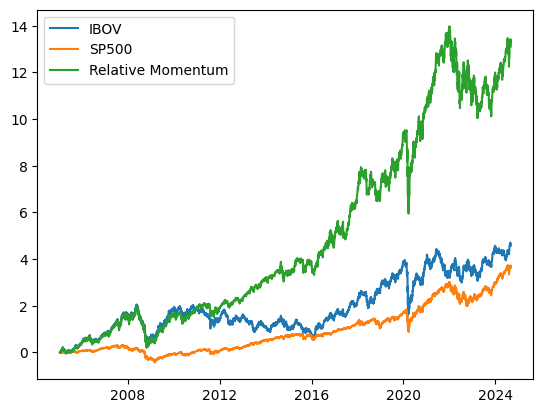

In [109]:
plt.plot(relative_momentum_eval)
plt.legend(relative_momentum_eval.columns)
plt.show()

In [111]:
rm_avg_return = relative_momentum_eval.resample('YE').last().pct_change().mean()
rm_avg_vol = relative_momentum.std() * (252 ** 0.5)

relative_momentum_results = pd.concat([rm_avg_return, rm_avg_vol], keys=['Avg Return', 'Avg Vol'], axis=1)

relative_momentum_results

,Avg Return,Avg Vol
IBOV,0.278243,0.268653
SP500,0.266898,0.194846
Relative Momentum,0.350569,0.239419


In [112]:
relative_momentum_results['Sharpe Ratio'] = (relative_momentum_results['Avg Return'] - risk_free_rate) / relative_momentum_results['Avg Vol']

relative_momentum_results

,Avg Return,Avg Vol,Sharpe Ratio
IBOV,0.278243,0.268653,0.635553
SP500,0.266898,0.194846,0.818075
Relative Momentum,0.350569,0.239419,1.015244
